In [1]:
# sys, file and nav packages:
import datetime as dt
import json

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns

import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

start_date = '2020-03-01'
end_date ='2021-05-31'

a_qty = 20

a_fail_rate = .1

unit_label = 'p/100m'
reporting_unit = 100

# name of the output folder:
name_of_project = 'dist_map'

# get your data:
df= pd.read_csv('checked_sdata_eos_2020_21.csv')

with open("river_basins.json", "r") as infile:
    river_bassins = json.load(infile)

dfBeaches = pd.read_csv("beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("codes_with_group_names_2015.csv")
dfDims = pd.read_csv("corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)
        
dfCodes.set_index("code", inplace=True)

# Changes in Spearmans $\rho$ as buffer size changes

Spearmans ranked test for correlation is being used to test the association of the number of objects found on the beach with the type of land use within a defined radius of the location where the objects were found.

The national survey on land use is the source for the classification of land use types. For every 100m² of the national territory there is an attributed land use classification based on the analysis of aerial images.

In [2]:
# this is the aggregated survey data that is being used
fd = df.copy()
fd['loc_dates'] = list(zip(fd.location.values, fd.date.values))
fd['date'] = pd.to_datetime(fd.date)

# get rid of microplastics except for GPI
mcr = df[df.groupname == "micro plastics (< 5mm)"].code.unique()
micro = [x for x in mcr if x != "G112"]
fd = fd[~fd.code.isin(micro)]

# the location data for the surveys
dfb = dfBeaches.loc[fd.location.unique()].copy()


In [3]:
# the landuse descriptors are integers, key them to a readable descriptor
# the source is https://www.bfs.admin.ch/bfs/fr/home/statistiques/espace-environnement/enquetes/area.html
# using column AS1827
label_keys = {
    1:"industrial",
    2:"residential",
    3:"government",
    4:"agg_buildings",
    5:"unk_building",
    6:"roads",
    7:"railways",
    8:"airports",
    9:"special",
    10:"recreational",
    11:"orchards",
    12:"vineyards",
    13:"horticulture",
    14:"arable",
    15:"meadows",
    16:"farmpastures",
    17:"alpinemeadows",
    18:"aplinepasteurs",
    19:"closed_forest",
    20:"open_forest",
    21:"brush_forest",
    22:"woods",
    23:"lakes",
    24:"rivers",
    25:"unproductive",
    26:"bareland",
    27:"glaciers"
}

key_labels = {v:k for k,v in label_keys.items()}

# group the land use into functional groups
# land use categories that are to be tested alone
# should be in their own group
group_parts = {'buildings':[2,3,4,5,9],
               'ind':[1],              
               'trans':[6,7,8],
               'recreation':[10],
               'agg':[11, 12, 13, 14, 15, 16, 18],
               'woods':[17,19,20,21,22],
               'water':[23,24],
               'unproductive':[25,26,27]
              }

# make column names based on the key values:
as_1827_part ={k:F"part_{v}" for k,v in label_keys.items()}

# this is the final value that is being tested against
# the survey results. Map survey results to these 
# aggregated luse features
som_cols = ['% to buildings',
            '% to ind',
            '% to trans',
            '% to recreation',
            '% to agg',
            '% to woods',
            '% to water',
            '% to unproductive',
                
]

key_labels.update({'luse_total':'total','water_value':'water_value', 'adjusted_land_use':'adjusted_land_use'})
cols_lu = ['recreational', 'farmpastures', 'closed_forest', 'rivers',
       'residential', 'roads', 'unproductive', 'industrial', 'railways',
       'woods', 'arable', 'special', 'government', 'unk_building', 'lakes',
       'meadows', 'horticulture', 'orchards', 'agg_buildings', 'bareland',
       'open_forest', 'vineyards', 'airports', 'brush_forest',
       'aplinepasteurs', 'alpinemeadows', 'glaciers','luse_total',
       'water_value', 'adjusted_land_use']

# define functions to map luse data to survey locations
def aggregate_buffer_data(data, cols, bufferdata, label_keys, **kwargs):
    """Maps values of <bufferdata> to <data> using the values in data.index.
    Each location is assigined a value from the <buffer data>. If the
    location does not have any corresponding buffer data it is assigned 0.
    
    :param data: A data frame with the locations
        of interest as the index.
    :type data: pandas.core.frame.DataFrame
    :param cols: A list of the new column names from
        the buffer data
    :type cols: list, array of column names
    :param bufferdata: A dataframe with two columns
        one for the landuse name and the other for the
        cumulative sum of that feature from the buffer
    :type bufferdata: pandas.core.frame.DataFrame
    :param label_keys: A mapping of numerical categories to labels
    :type label_keys: dict
    :return: The orginal data frame with the new columns added
    """
    
    # make empty columns for the measured land use features
    for acol in cols:
        data[acol]= 0

    # assign the land use value to each location
    for beach in data.index:
        # for each category of land use
        for label in list(label_keys):
            # assign a value
            try:
                new_data = bufferdata[(bufferdata.location == beach)&(bufferdata.label == label)].AS18_27.values[0]
            except:
                new_data = 0
            # assign that value to the location data
            data.loc[beach, label] = new_data
    
    return data

# account for the area attributed to water by removing the
# the value of water features from land use total
def adjusted_land_use(data, col_keys):
    """Account for the area attributed to water by removing the
    the value of water features from land use total.
    
    :param data: A data frame with the column luse_total
    :type data: pandas.core.frame.DataFrame
    :param col_keys: The column names of all non water land
        use columns.
    :type cols: list, array of column names
    :return: The orginal data frame with the new columns added
    """
    # total land use
    data['luse_total'] = data.loc[:,list(col_keys)].sum(axis=1)

    # amount attributed to water
    data['water_value'] = data.loc[:, ['lakes','rivers']].sum(axis=1)

    # the adjsuted land use
    # remove the water value from land use stats
    data['adjusted_land_use'] = data.luse_total - data.water_value
    
    return data

# determine the ratio of each landuse feature to the adjusted total for each buffer
def account_for_adj_luse(data, col_keys):
    """Uses the adjusted land use total to determine
    the % total for each feature.
    
    :param data: A data frame with the defined land use columns
    :type data: pandas.core.frame.DataFrame
    :param col_keys: The column names of all non water land
        use columns.
    :type cols: list, array of column names
    :return: The data frame with the part of total of the
        adjsuted land use for each AS1827 category
    """
    for label in list(col_keys.values()):
        a_label = F"part_{label}"
        data[a_label] = data[label]/data['adjusted_land_use']
    return data

# merge survey results to land use stats
def assign_luse_stat_to_survey_results(sdata, luse_data, som_cols):
    for a_beach in sdata.location.unique():
        for element in som_cols:
            sdata.loc[sdata.location == a_beach, element] = luse_data.loc[a_beach, element]
    return sdata

# apply method and check results
def check_hypothesis(this_data, some_codes, variables, method):
    myresults = {}
    for i,code in enumerate(some_codes):
        data = this_data[this_data.code == code]
        code_results ={code:{}}
        for j, n in enumerate(variables):
            corr, a_p = method(data[n], data[unit_label])
            if a_p <= 0.05:
                code_results[code].update({n:corr})
            else:
                code_results[code].update({n:"X"})
        myresults.update(code_results)
    
    return myresults


def make_col_totals(luse,key_labels, cols, colname='1500', idx='id'):
    x = luse[cols].copy()
    
    x.loc[colname]= x.sum(numeric_only=True, axis=0)
    
    y = x.loc[colname]

    a_tot = pd.DataFrame(index=y.index, data=y)

    a_tot[idx] = a_tot.index.map(lambda x: key_labels[x])
    
    return a_tot 
def agguse_groups(data, group_parts):
    wiw = {}
    for a_group in group_parts.keys():
        part_groups = [data.loc[x] for x in group_parts[a_group]]
        this_g = sum(part_groups)
        wiw.update({a_group:this_g})     
    
    return wiw
def landuse_per_radius(s, key_labels=key_labels, cols_lu=cols_lu, colname=1500, idx="id"):
    b = make_col_totals(s,key_labels, cols_lu, colname=radius, idx='id').set_index("id", drop=True)
    yi= agguse_groups(b, group_parts)
    c = pd.DataFrame.from_dict(yi, orient='index').append(b.loc[['total','water_value', 'adjusted_land_use']])
    return c

In [4]:
# aggregate the groups
def aggregate_the_luse_groups(data, group_parts, as_1827_part):
    """Makes new columns and makes a subtotal column for the
    newly created groups. Aggregates the functional groups defined
    by land use.
        
    :param data: A data frame with the defined land use columns
    :type data: pandas.core.frame.DataFrame
    :param group_parts: A dictionary that maps names to a list
        of column values.
    :type group_parts: dict
    :param as_1827_part: The AS1827 keys to labels dict
    :type as_1827_part: dict
    return: The data frame with the % of total of the
        adjsuted land use for each functional category
    """
    
    for a_group in group_parts.keys():
        part_groups = [as_1827_part[x] for x in group_parts[a_group]]
        new_group = F"% to {a_group}"
        data[new_group] = data.loc[:,part_groups].sum(axis=1)
    
    return data

def aggregate_adjust_account(data, add_these_cols, bufferdata, label_keys={}):
    data = aggregate_buffer_data(data, add_these_cols, bufferdata, list(label_keys.values()))
    data = adjusted_land_use(data, list(label_keys.values()))
    data = account_for_adj_luse(data, label_keys)
    
    return data


def make_bufferdata(a_file_name, a_col="AS18_27", label_keys={}):
    # these are the land use results
    d = pd.read_csv(a_file_name)
    if "slug" in d.columns:
        d.rename(columns={"slug":"location"}, inplace=True)
    else:
        pass

    # the buffer results from qgis
    e = d[[a_col, "location"]].copy()

    # make a df with location slug, landuse label and land use value:
    for a_num in e[a_col].unique():
        e.loc[e[a_col]==a_num, "label"]=label_keys[a_num]

    # counting the number of points inside the buffer for each location and category
    bufferdata = e.groupby(['location','label'], as_index=False)[a_col].count()
    
    return bufferdata


def check_rho_for_this_radius(data, fd, add_these_cols, bufferdata, radius=1500, label_keys=label_keys, group_parts=group_parts,
                              som_cols=som_cols, as_1827_part=as_1827_part, abundant_codes=[]):
    
    # apply the defined groups, adjust and account for
    # the value of the water feature in the total land use
    data = aggregate_adjust_account(data, add_these_cols, bufferdata, label_keys=label_keys)

    # define the % of total land use for each group
    s = aggregate_the_luse_groups(data, group_parts, as_1827_part)

    # tag each result with the radius
    s['dist'] = radius
    
    # assign the land use to the survey result
    fd_luse = assign_luse_stat_to_survey_results(fd, s,som_cols) 
    this_data = fd_luse[[unit_label,*som_cols, 'code']]
    
    # check rho for each value
    myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)
    a = pd.DataFrame.from_dict(myresults, orient='index')
    a.replace('X', 0, inplace=True)
    a["dist"] = radius
    
    return a, s

### Definition of abundant_codes

Currently the <abundant_codes> is defined as any object that had a value greater than <a_qty> at any survey. That is one possible way to find codes that may have an association. There are others.

In [5]:
# the current definition of abundant codes
abundant_codes = fd[fd.quantity > 20].code.unique()

# the fail rate is another way to differentiate
# define abundant codes by fail rate
agg_this = {"quantity":"sum", "p/100m":"sum", "fail":"sum"}
c_totals = fd.groupby("code", as_index=False).agg(agg_this)
c_totals["fr"] = c_totals["fail"]/fd.loc_date.nunique()

fail_codes = c_totals[c_totals.fr > .1].code.unique()

### 1500 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [6]:
# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())
radius = 1500

# the functional land use groups:
these_groups = list(group_parts.keys())
# the bufferdata for this radius
bufferdata = make_bufferdata("noas04_27.csv", a_col="AS18_27", label_keys=label_keys)

add_these_cols = bufferdata.label.unique()

a1500, s = check_rho_for_this_radius(data, fd, add_these_cols, bufferdata, radius, label_keys=label_keys, group_parts=group_parts,
                              som_cols=som_cols, as_1827_part=as_1827_part, abundant_codes=abundant_codes)

totals=[]
totals.append(landuse_per_radius(s))

a1500.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True)

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist
G904,-0.130361,-0.118668,-0.203706,0.000000,0.000000,0.165436,0.000000,0.156999,1500
G944,-0.109755,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1500
G67,-0.102809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1500
G208,0.000000,0.000000,0.000000,0.000000,-0.162151,-0.145427,0.000000,-0.131374,1500
G137,0.000000,-0.104203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1500
G10,0.000000,0.000000,0.000000,0.000000,-0.135936,0.000000,0.000000,-0.107094,1500
G89,0.000000,0.000000,0.000000,0.000000,-0.118790,0.000000,0.000000,0.000000,1500
G38,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1500
G149,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.102102,1500
G22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1500


### 2000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [7]:
# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())
radius = 2000



# the functional land use groups:
these_groups = list(group_parts.keys())
# the bufferdata for this radius
bufferdata = make_bufferdata("luse_2000.csv", a_col="AS18_27", label_keys=label_keys)

add_these_cols = bufferdata.label.unique()

a2000, s = check_rho_for_this_radius(data, fd, add_these_cols, bufferdata, radius, label_keys=label_keys, group_parts=group_parts,
                              som_cols=som_cols, as_1827_part=as_1827_part, abundant_codes=abundant_codes)
a2000.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True)

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist
G904,-0.171929,-0.160102,-0.240899,0.000000,0.000000,0.187936,0.000000,0.153292,2000
G67,-0.150838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2000
G944,-0.105260,0.000000,0.000000,0.000000,0.000000,0.117210,0.000000,0.000000,2000
G208,0.000000,0.000000,0.128866,0.000000,-0.111470,-0.140369,0.000000,-0.133486,2000
G89,0.000000,0.000000,0.000000,0.000000,-0.160052,0.000000,0.000000,0.000000,2000
G21,0.000000,0.000000,0.000000,0.000000,-0.144680,0.000000,0.000000,0.000000,2000
G22,0.000000,0.000000,0.000000,0.000000,-0.109336,0.000000,0.000000,0.000000,2000
G38,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2000
G149,0.000000,0.000000,0.102971,0.000000,0.000000,0.000000,0.000000,0.000000,2000
G10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.107886,2000


In [8]:
abund_sum = fd[fd.code.isin(abundant_codes)].quantity.sum()
total_sum = fd.quantity.sum()
print('total items sampled (excluding micro):', fd.quantity.sum())
print('total most common items:', abund_sum)
print('proportion of most common items:', abund_sum/total_sum)
print('number of items found more than 20 times:', len(abundant_codes))

total items sampled (excluding micro): 52437
total most common items: 44505
proportion of most common items: 0.8487327650323245
number of items found more than 20 times: 38


In [9]:
abund_quantity = fd[fd.code.isin(abundant_codes)]
Dfabund_quantity = abund_quantity.groupby('code').agg({'quantity': 'sum', 'pcs_m':'mean'}).round(6) ### or mean for pcs_m??? 
Dfabund_quantity.sort_values(by='quantity',ascending=False).head()
Dfabund_quantity.reset_index(inplace=True)
#Dfabund_quantity.pcs_m.unique()

In [10]:
df_codes = dfCodes.reset_index()
abund_codes_names = df_codes[df_codes.code.isin(abundant_codes)]
DfAdd = pd.merge(Dfabund_quantity, abund_codes_names, on = 'code')
a2000.index.name = 'code'


In [11]:
a2000.reset_index(inplace=True)

df2000 = pd.merge(a2000, DfAdd, on = 'code')
df2000.sort_values(by='quantity',ascending=False).iloc[20:23,:]
#df2000.pcs_m.unique()

,code,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist,...,description,source,source_two,source_three,parent_code,direct,single_use,micro,ospar_code,groupname
29,G73,0.115739,0.109175,0.103307,0.0,0.000000,0.000000,0.000000,0.000000,2000,...,Foamed items & pieces (non packaging/insulatio...,Recreation,Utility,Unknown,Parent code,True,False,False,45,recreation
24,G904,-0.171929,-0.160102,-0.240899,0.0,0.000000,0.187936,0.000000,0.153292,2000,...,"Fireworks; rocket caps, exploded parts & packa...",Recreation,Where does it come from,none,G124,False,True,False,48,recreation
9,G3,0.000000,0.000000,0.000000,0.0,-0.136098,0.126791,-0.107082,0.000000,2000,...,Bags; plastic shopping/carrier/grocery and pieces,Packaging,Food and drink,none,Parent code,True,True,False,2,packaging non food


In [12]:
df2000.iloc[:,10:22].head(10)

,quantity,pcs_m,material,description,source,source_two,source_three,parent_code,direct,single_use,micro,ospar_code
0,8485,0.542772,Plastic,Cigarette filters,Tobacco,Where does it come from,none,Parent code,True,True,False,64
1,2136,0.161710,Glass,"Glass drink bottles, pieces",Packaging,Food and drink,none,Parent code,True,True,False,91
2,231,0.014611,Glass,Ceramic tile and pieces,Construction,Where does it come from,none,G204,False,False,False,94
3,3325,0.236451,Plastic,"Food wrappers; candy, snacks",Packaging,Food and drink,none,Parent code,True,True,False,19
4,2534,0.189326,Plastic,Industrial sheeting,Utility items,Industry,none,Parent code,False,False,False,40
5,1406,0.106788,Plastic,Cotton bud/swab sticks,Personal hygiene,Water Treatment,Indirect,Parent code,False,True,False,98
6,160,0.011969,Plastic,"Coverings; plastic packaging, sheeting for pro...",Packaging,Industrial,none,Parent code,False,True,False,40
7,1968,0.142332,Plastic,Industrial pellets (nurdles),Industry,Where does it come from,Indirect,Parent code,False,False,True,none
8,588,0.035440,Plastic,Diapers - wipes,Personal hygiene,Where does it come from,none,Parent code,True,True,False,102
9,285,0.020337,Plastic,Bags; plastic shopping/carrier/grocery and pieces,Packaging,Food and drink,none,Parent code,True,True,False,2


In [13]:
df2000.loc[df2000.source.isin(['Tobacco']) |
           df2000.source_two.isin(['Smoking related']),'Type'] ='Tobacco'

df2000.loc[df2000.source.isin(['Industry','Construction', 'Industrial', 'Manufacturing']) |
           df2000.source_two.isin(['Industry','Construction', 'Industrial','Manufacturing'])  | 
           df2000.source_three.isin(['Industry','Construction', 'Industrial','Manufacturing']),'Type'] ='Industry'


df2000.loc[df2000.source.isin(['Personal hygiene']) |
           df2000.source_two.isin(['Water treatment']),'Type'] ='Sanitary'

df2000.loc[df2000.description.isin(['Paper packaging']) |
           df2000.description.isin(['Packaging films nonfood or unknown']),'Type'] ='Packaging (non-food)'


df2000.loc[df2000.source_two.isin(['Food and drink']) |
           df2000.description.isin(['Foil wrappers, aluminum foil']) |
           df2000.source_two.isin(['Food and drinks']),'Type'] ='Food and drinks'

df2000.loc[df2000.description.isin(['Plastic fragments angular <5mm']) |
           df2000.description.isin(['Styrofoam < 5mm']) |
           df2000.description.isin(['Plastic fragments rounded <5mm']) |
           df2000.description.isin(['Foamed  plastic <5mm']) |
           df2000.description.isin(['Fragmented plastics']),'Type'] ='Plastic fragments and pieces'
df2000.loc[df2000.Type.isna(), 'Type'] = 'Others'
df2000[df2000.Type == 'Others'].description.unique()
#DfIndCostr.description.unique()

array(['Glass or ceramic fragments > 2.5 cm',
       'Lid/cap rings from plastic bottles/containers',
       'Shotgun cartridges', 'Lids for chemicals, detergents (non-food)',
       'Lids unidentified',
       'Foamed EVA (flexible plastic) for crafts & watersports',
       'Fireworks; rocket caps, exploded parts & packaging',
       'Octopus pots', 'Clothing, towels & rags',
       'Fireworks paper tubes and fragments',
       'Foamed items & pieces (non packaging/insulation) foamed sponge material',
       'Ribbons and bows', 'Labels, bar codes'], dtype=object)

In [14]:
DfType = df2000.groupby('Type').quantity.sum().reset_index()
DfType.sort_values(by='quantity',ascending=False,inplace=True)
DfType['Proportion'] = (DfType.quantity/DfType.quantity.sum())*100
DfType.Proportion = DfType.Proportion.round(decimals=1)
DfType.loc[DfType.Type=='Industry','Items'] = 'Expanded polystyrene, Industrial sheeting, Pellets, Foam packaging for insulation, Plastic construction waste, Ceramic tile and pieces, Plastic sheeting for large cargo items, Construction materials (bricks, pipes, cement), Pellet mass'
DfType.loc[DfType.Type=='Plastic fragments and pieces','Items'] = 'Fragmented plastics' 
DfType.loc[DfType.Type=='Tobacco','Items'] = 'Cigarette filters; Plastic packaging for tobacco'
DfType.loc[DfType.Type=='Sanitary','Items'] = 'Sanitary pads, tampons and applicators; Diapers and wipes; Tissues, toilet paper and paper towels, Cotton buds and swab sticks'
DfType.loc[DfType.Type=='Packaging (non-food)','Items'] = 'Paper packaging, Packaging films (not food-related)'
DfType.loc[DfType.Type=='Food and drinks','Items'] = 'Food wrappers, Glass bottles and pieces, Metal bottle caps, lids and pull tabs from cans, Drink lids, Aluminum foil, Plastic food containers, Plastic bags and pieces'
DfType.loc[DfType.Type=='Others','Items'] = 'Lids and cap rings from plastic bottles, Others lids, Shotgun cartridges, Foam items and pieces (not insulation), Fireworks (rocket caps, exploded parts and packaging), Lids for chemicals and detergents, Labels and bar codes, Foamed EVA, Glass and ceramic fragments (> 2.5 cm), Fireworks (paper parts), Clothing and rags, Ribbons and bows, Octopus pots'
print('Total industrial items over total macrolitter items:', DfType[DfType.Type=='Industry'].quantity.sum()/total_sum )

Total industrial items over total macrolitter items: 0.2538093331044873


In [15]:
DfType.sort_values(by='quantity',ascending=False)

,Type,quantity,Proportion,Items
1,Industry,13309,29.9,"Expanded polystyrene, Industrial sheeting, Pel..."
6,Tobacco,9134,20.5,Cigarette filters; Plastic packaging for tobacco
0,Food and drinks,8038,18.1,"Food wrappers, Glass bottles and pieces, Metal..."
4,Plastic fragments and pieces,7400,16.6,Fragmented plastics
2,Others,3159,7.1,"Lids and cap rings from plastic bottles, Other..."
5,Sanitary,2450,5.5,"Sanitary pads, tampons and applicators; Diaper..."
3,Packaging (non-food),1015,2.3,"Paper packaging, Packaging films (not food-rel..."


In [16]:
df2000_vis = df2000.copy()
df2000_vis = df2000_vis.sort_values(by='quantity',ascending=False)
df2000_vis['description'] = df2000_vis['description'].replace('Industrial pellets (nurdles)', 'Pellets') 
df2000_vis['description'] = df2000_vis['description'].replace('Glass drink bottles, pieces', 'Glass bottles and pieces') 
df2000_vis['description'] = df2000_vis['description'].replace('Food wrappers; candy, snacks', 'Food wrappers') 
df2000_vis['description'] = df2000_vis['description'].replace('Food wrappers; candy, snacks', 'Food wrappers') 
df2000_vis['description'] = df2000_vis['description'].replace('Foam packaging/insulation/polyurethane', 'Foam packaging for insulation') 
df2000_vis['description'] = df2000_vis['description'].replace('Packaging films nonfood or unknown', 'Packaging films (not food-related)') 
df2000_vis['description'] = df2000_vis['description'].replace('Lids unidentified', 'Other lids') 
df2000_vis['description'] = df2000_vis['description'].replace('Tobacco; plastic packaging, containers', 'Plastic packaging for tobacco') 
df2000_vis['description'] = df2000_vis['description'].replace('Fireworks paper tubes and fragments', 'Fireworks (paper parts)') 
df2000_vis['description'] = df2000_vis['description'].replace('Diapers - wipes', 'Diapers and wipes') 
df2000_vis['description'] = df2000_vis['description'].replace('Foamed items & pieces (non packaging/insulation) foamed sponge material', 'Foam items and pieces (not insulation)') 
df2000_vis['description'] = df2000_vis['description'].replace('Labels, bar codes', 'Labels and bar codes') 
df2000_vis['description'] = df2000_vis['description'].replace('Sanitary pads /panty liners/tampons and applicators', 'Sanitary pads, tampons and applicators') 
df2000_vis['description'] = df2000_vis['description'].replace('Pellet mass from injection molding', 'Pellet mass') 
df2000_vis['description'] = df2000_vis['description'].replace('Bags; plastic shopping/carrier/grocery and pieces', 'Plastic bags and pieces') 
df2000_vis['description'] = df2000_vis['description'].replace('Lids for chemicals, detergents (non-food)', 'Lids for chemicals and detergents') 
df2000_vis['description'] = df2000_vis['description'].replace('Coverings; plastic packaging, sheeting for protecting large cargo items', 'Plastic sheeting for large cargo items') 
df2000_vis['description'] = df2000_vis['description'].replace('Construction material; bricks, pipes, cement', 'Construction materials (bricks, pipes, cement)') 
df2000_vis['description'] = df2000_vis['description'].replace('Fireworks; rocket caps, exploded parts & packaging', 'Fireworks (rocket caps, exploded parts and packaging)') 
df2000_vis['description'] = df2000_vis['description'].replace('Foamed EVA (flexible plastic) for crafts & watersports', 'Foamed EVA') 
df2000_vis['description'] = df2000_vis['description'].replace('Metal bottle caps, lids & pull tabs from cans', 'Metal bottle caps, lids and pull tabs from cans') 
df2000_vis['description'] = df2000_vis['description'].replace('Lid/cap rings from plastic bottles/containers', 'Lids and cap rings from plastic bottles') 
df2000_vis['description'] = df2000_vis['description'].replace('Tissue, toilet paper, napkins, paper towels', 'Tissues, toilet paper and paper towels') 
df2000_vis['description'] = df2000_vis['description'].replace('Cotton bud/swab sticks', 'Cotton buds and swab sticks') 
df2000_vis['description'] = df2000_vis['description'].replace('Foil wrappers, aluminum foil', 'Aluminum foil') 
df2000_vis['description'] = df2000_vis['description'].replace('Clothing, towels & rags', 'Clothing and rags') 
df2000_vis['description'] = df2000_vis['description'].replace('Food containers single use foamed or plastic', 'Plastic food containers') 
df2000_vis['description'] = df2000_vis['description'].replace('Plastic fragments angular <5mm', 'Angular plastic fragments (< 0.5 cm)') 
df2000_vis['description'] = df2000_vis['description'].replace('Plastic fragments rounded <5mm', 'Round plastic fragments (< 0.5 cm)') 
df2000_vis['description'] = df2000_vis['description'].replace('Foamed  plastic <5mm', 'Foam plastic (< 0.5 cm)') 
df2000_vis['description'] = df2000_vis['description'].replace('Styrofoam < 5mm', 'Styrofoam fragments (< 0.5 cm)') 
df2000_vis['description'] = df2000_vis['description'].replace('Glass or ceramic fragments > 2.5 cm', 'Glass and ceramic fragments (> 2.5 cm)')


'Industrial pellets (nurdles)': 'Pellets', 
'Glass drink bottles, pieces': 'Glass bottles and pieces', 
'Food wrappers; candy, snacks': 'Food wrappers', 
'Food wrappers; candy, snacks': 'Food wrappers', 
'Foam packaging/insulation/polyurethane', 'Foam packaging for insulation', 
'Packaging films nonfood or unknown': 'Packaging films (not food-related)', 
'Lids unidentified': 'Other lids', 
'Tobacco; plastic packaging, containers': 'Plastic packaging for tobacco', 
'Fireworks paper tubes and fragments': 'Fireworks (paper parts)', 
'Diapers - wipes': 'Diapers and wipes', 
'Foamed items & pieces (non packaging/insulation) foamed sponge material': 'Foam items and pieces (not insulation)', 
'Labels, bar codes': 'Labels and bar codes', 
'Sanitary pads /panty liners/tampons and applicators': 'Sanitary pads, tampons and applicators', 
'Pellet mass from injection molding': 'Pellet mass', 
'Bags; plastic shopping/carrier/grocery and pieces': 'Plastic bags and pieces', 
'Lids for chemicals, detergents (non-food)': 'Lids for chemicals and detergents', 
'Coverings; plastic packaging, sheeting for protecting large cargo items': 'Plastic sheeting for large cargo items', 
'Construction material; bricks, pipes, cement': 'Construction materials (bricks, pipes, cement)', 
'Fireworks; rocket caps, exploded parts & packaging': 'Fireworks (rocket caps, exploded parts and packaging)', 
'Foamed EVA (flexible plastic) for crafts & watersports': 'Foamed EVA', 
'Metal bottle caps, lids & pull tabs from cans': 'Metal bottle caps, lids and pull tabs from cans', 
'Lid/cap rings from plastic bottles/containers': 'Lids and cap rings from plastic bottles', 
'Tissue, toilet paper, napkins, paper towels': 'Tissues, toilet paper and paper towels', 
'Cotton bud/swab sticks': 'Cotton buds and swab sticks', 
'Foil wrappers, aluminum foil': 'Aluminum foil', 
'Clothing, towels & rags': 'Clothing and rags', 
'Food containers single use foamed or plastic': 'Plastic food containers', 
'Plastic fragments angular <5mm': 'Angular plastic fragments (< 0.5 cm)', 
'Plastic fragments rounded <5mm': 'Round plastic fragments (< 0.5 cm)', 
'Foamed  plastic <5mm': 'Foam plastic (< 0.5 cm)', 
'Styrofoam < 5mm': 'Styrofoam fragments (< 0.5 cm)', 
'Glass or ceramic fragments > 2.5 cm': 'Glass and ceramic fragments (> 2.5 cm)', 
    
    
'dist', 'material', 'quantity', 'pcs_m','code'], axis=1)

df2000v.set_index('description', inplace=True)
new_column_names = {
    "% to buildings":"Buildings",
    "% to ind":"Industries",
    "% to trans":"Roads",
    "% to recreation":"Recreational",
    "% to agg":"Agriculture",
    "% to woods":"Forests",
    "% to water":"Rivers/canals",
    "% to unproductive":"Unproductive"
}
df2000v.rename(columns=new_column_names, inplace=True)
df2000v = df2000v[['Buildings','Industries', 'Recreational','Agriculture','Forests', 'Unproductive', 'Roads','Rivers/canals']]
df2000v.iloc[20:22,:]

,Buildings,Industries,Recreational,Agriculture,Forests,Unproductive,Roads,Rivers/canals
description,,,,,,,,
Foam items and pieces (not insulation),0.115739,0.109175,0.0,0.0,0.000000,0.000000,0.103307,0.0
"Fireworks (rocket caps, exploded parts and packaging)",-0.171929,-0.160102,0.0,0.0,0.187936,0.153292,-0.240899,0.0


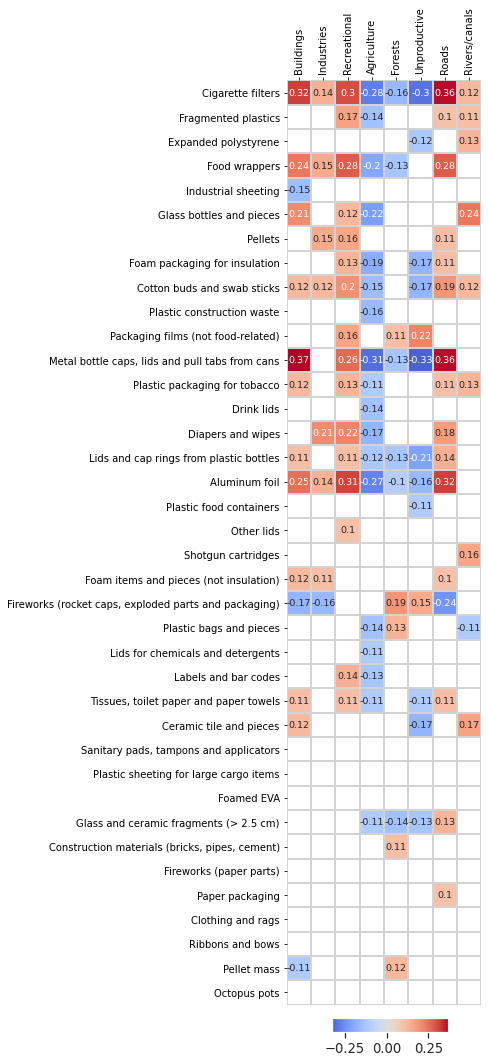

In [17]:
fig, ax= plt.subplots(figsize=(17,17))


sns.set(font_scale=1.2)

ax = sns.heatmap(df2000v.round(decimals=2), annot=True, fmt="g", cmap='coolwarm', annot_kws={"size":9.5}, center =0, mask=df2000v==0, square = True, 
                linewidths=0.1,linecolor="lightgrey", cbar = False, ax = ax)
ax.set_ylabel('')
ax.xaxis.tick_top() 
ax.yaxis.tick_left()

ax.xaxis.set_label_position('top')
ax.set_xticklabels(['Buildings','Industries', 'Recreational', 'Agriculture', 'Forests', 'Unproductive', 'Roads', 'Rivers/canals'],rotation=90)

# what does this do?
ax_divider = make_axes_locatable(ax)
#cax = ax_divider.append_axes(anchor=(1.0,0.0), size = '2%', pad = '5%')

# how does this work?
axins = inset_axes(ax,
                   width="60%",  # width = 5% of parent_bbox width
                   height="1.5%",  # height : 50%
                   loc='lower center',
                   bbox_to_anchor=(0.03, -0.03, 1, 1),
                   bbox_transform=ax.transAxes, 
                   borderpad=0
                   )


fig.colorbar(ax.get_children()[0], cax = axins, orientation = 'horizontal', extendfrac='auto')

# plt.savefig('C:/Users/schre086/figures/land_use_ch/corr_matrix.png', bbox_inches='tight')

plt.show()

In [18]:
DfCorr = df2000.iloc[:,:14]
DfCorr = DfCorr.drop(['dist','material'], axis=1)
DfCorr[DfCorr !=0].count()

code                 38
% to buildings       14
% to ind              8
% to trans           16
% to recreation      16
% to agg             18
% to woods           11
% to water            9
% to unproductive    13
quantity             38
pcs_m                38
description          38
dtype: int64

In [19]:
DfCorr.head()

,code,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,quantity,pcs_m,description
0,G27,0.320302,0.142424,0.359557,0.302469,-0.284461,-0.164146,0.123172,-0.298779,8485,0.542772,Cigarette filters
1,G200,0.212790,0.000000,0.000000,0.116170,-0.219870,0.000000,0.241411,0.000000,2136,0.161710,"Glass drink bottles, pieces"
2,G921,0.120313,0.000000,0.000000,0.000000,0.000000,0.000000,0.169742,-0.172626,231,0.014611,Ceramic tile and pieces
3,G30,0.239966,0.151797,0.277116,0.275198,-0.202422,-0.133838,0.000000,0.000000,3325,0.236451,"Food wrappers; candy, snacks"
4,G67,-0.150838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2534,0.189326,Industrial sheeting


In [20]:
print('buildings',DfCorr.loc[DfCorr['% to buildings']!=0, 'quantity'].sum())
print('industry',DfCorr.loc[DfCorr['% to ind']!=0, 'quantity'].sum())
print('road network',DfCorr.loc[DfCorr['% to trans']!=0, 'quantity'].sum())
print('recreation',DfCorr.loc[DfCorr['% to recreation']!=0, 'quantity'].sum())
print('agriculture',DfCorr.loc[DfCorr['% to agg']!=0, 'quantity'].sum())
print('forest',DfCorr.loc[DfCorr['% to woods']!=0, 'quantity'].sum())
print('rivers',DfCorr.loc[DfCorr['% to water']!=0, 'quantity'].sum())
print('unproductive',DfCorr.loc[DfCorr['% to unproductive']!=0, 'quantity'].sum())


buildings 21439
industry 16929
road network 28428
recreation 31231
agriculture 30248
forest 15356
rivers 26546
unproductive 21178


In [21]:
21439/df2000_vis.quantity.sum()

0.48172115492641276

In [22]:
df2000_vis.material.unique()

array(['Plastic', 'Glass', 'Metal', 'Paper', 'Cloth'], dtype=object)

In [23]:
print('Total plastic items:', df2000_vis[df2000_vis.material=='Plastic'].quantity.sum())
print('Proportion plastic items over all macrolitter items:', df2000_vis[df2000_vis.material=='Plastic'].quantity.sum()/df2000_vis.quantity.sum())
print('Proportion glass items over all macrolitter items:',df2000_vis[df2000_vis.material=='Glass'].quantity.sum()/df2000_vis.quantity.sum())
print('Proportion paper items over all macrolitter items:',df2000_vis[df2000_vis.material=='Paper'].quantity.sum()/df2000_vis.quantity.sum())
print('Proportion metal items over all macrolitter items:',df2000_vis[df2000_vis.material=='Metal'].quantity.sum()/df2000_vis.quantity.sum())
print('Proportion cloth items over all macrolitter items:',df2000_vis[df2000_vis.material=='Cloth'].quantity.sum()/df2000_vis.quantity.sum())

Total plastic items: 40013
Proportion plastic items over all macrolitter items: 0.8990675205033143
Proportion glass items over all macrolitter items: 0.05992585102797438
Proportion paper items over all macrolitter items: 0.010920121334681496
Proportion metal items over all macrolitter items: 0.027435119649477587
Proportion cloth items over all macrolitter items: 0.0026513874845522974


In [24]:
df2000_vis.head()

#df2000_vis[df2000_vis != 0].count()

,code,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist,...,source,source_two,source_three,parent_code,direct,single_use,micro,ospar_code,groupname,Type
0,G27,0.320302,0.142424,0.359557,0.302469,-0.284461,-0.164146,0.123172,-0.298779,2000,...,Tobacco,Where does it come from,none,Parent code,True,True,False,64,tobacco,Tobacco
35,Gfrags,0.000000,0.000000,0.104783,0.172020,-0.139831,0.000000,0.107763,0.000000,2000,...,Undefined,None,None,Parent code,True,False,False,46,plastic pieces,Plastic fragments and pieces
36,Gfoam,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130208,-0.117913,2000,...,Undefined,Packaging,Construction,Parent code,False,False,False,46,infrastructure,Industry
3,G30,0.239966,0.151797,0.277116,0.275198,-0.202422,-0.133838,0.000000,0.000000,2000,...,Packaging,Food and drink,none,Parent code,True,True,False,19,food and drink,Food and drinks
4,G67,-0.150838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2000,...,Utility items,Industry,none,Parent code,False,False,False,40,agriculture,Industry


In [25]:
DfTop20 = df2000_vis.iloc[:20,:]
DfTop20 = DfTop20[['description', 'quantity','Type']]
DfTop20.quantity.sum()/total_sum

0.7874020252874878

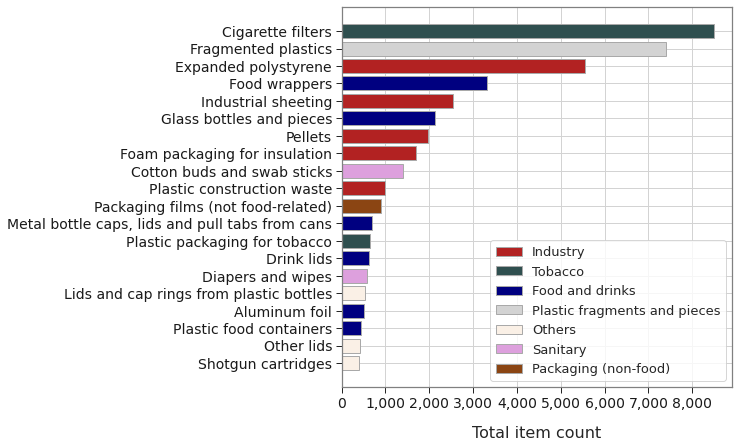

In [26]:
fig, ax = plt.subplots(figsize=(7,7))
#sns.set_style("darkgrid")
colors = {'Industry': 'firebrick', 'Tobacco': 'darkslategrey', 'Food and drinks': 'navy', 'Plastic fragments and pieces':'lightgrey',
         'Others':'linen','Sanitary':'plum','Packaging (non-food)':'saddlebrown'}
N = 3
ind = np.arange(N)
width = 0.6

#for ha in handles:
 #   ha.set_edgecolor("red")

labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
#handles.set_edgecolor("red")

ax.barh(DfTop20.description, DfTop20.quantity, color=[colors[i] for i in DfTop20['Type']], edgecolor='darkgrey')
ax.invert_yaxis()  
ax.set_ylabel('')
ax.set_xticks([0,1000,2000,3000,4000,5000,6000,7000,8000])
ax.set_xticklabels([0,'1,000','2,000','3,000','4,000','5,000','6,000','7,000','8,000'])

ax.set_xlabel('Total item count', fontsize=16, labelpad =15)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(labelcolor='k', labelsize=14, width=1)
ax.yaxis.grid(color='lightgray')
ax.xaxis.grid(color='lightgray')
ax.set_facecolor('white')

plt.legend(handles, labels, fontsize=13,facecolor='white')
for ha in ax.legend_.legendHandles:
    ha.set_edgecolor("darkgrey")

plt.grid(True)
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['bottom'].set_color('0.5')
ax.spines['left'].set_color('0.5')
#ax.tick_params(axis='both', which='minor', labelsize=8)


# plt.savefig('C:/Users/schre086/figures/land_use_ch/top_20items.png', bbox_inches='tight')

plt.show()


In [27]:
cols = ['% to buildings', '% to ind', '% to trans', '% to recreation', '% to agg', '% to woods', '% to water',      
'% to unproductive']

df2000_vis['corr_tot'] = df2000_vis[cols].apply(lambda x: (x!=0).sum(), axis=1)

test = df2000_vis.groupby('corr_tot').count().reset_index()
test

,corr_tot,code,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,...,source,source_two,source_three,parent_code,direct,single_use,micro,ospar_code,groupname,Type
0,0,7,7,7,7,7,7,7,7,7,...,7,7,6,7,7,7,7,6,7,7
1,1,9,9,9,9,9,9,9,9,9,...,9,9,5,9,9,9,9,5,9,9
2,2,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
3,3,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
4,4,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
5,5,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
6,6,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
7,7,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
8,8,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [28]:
cols_table = ['quantity','pcs_m','material', 'description', 'Type']

df2000_vis = df2000_vis[cols_table]
df2000_vis['% of total'] = ((df2000_vis.quantity)/total_sum)*100
df2000_vis = df2000_vis[['description','quantity','% of total','pcs_m','Type','material']]
df2000_vis.head()
# df2000_vis.to_csv('C:/Users/schre086/datasets/Switzerland/export_table.csv', index = False, header=True)

,description,quantity,% of total,pcs_m,Type,material
0,Cigarette filters,8485,16.181322,0.542772,Tobacco,Plastic
35,Fragmented plastics,7400,14.112173,0.592176,Plastic fragments and pieces,Plastic
36,Expanded polystyrene,5563,10.608921,0.435233,Industry,Plastic
3,Food wrappers,3325,6.340942,0.236451,Food and drinks,Plastic
4,Industrial sheeting,2534,4.832466,0.189326,Industry,Plastic


In [29]:
df2000_vis[df2000_vis.description == 'Octopus pots']

,description,quantity,% of total,pcs_m,Type,material
25,Octopus pots,30,0.057212,0.002772,Others,Glass


In [30]:
fd[(fd.code=='G207') & (fd.quantity==30)] 
## put to G200? 'Glass and ceramic fragments' 

,date,code,pcs_m,quantity,location,loc_date,water_name_slug,river_bassin,length,ilength,...,streets,month,eom,material,w_t,streets km,p/100m,area,loc_dates,% to ind
4190,2021-03-24,G207,1.07,30,anarchy-beach,"('anarchy-beach', '2021-03-24')",lac-leman,rhone,28.0,27.591973,...,48471,3,2021-03-31,Glass,l,48.471,107.0,0,"(anarchy-beach, 2021-03-24)",0.008621


In [31]:
df2000_vis.corr()

,quantity,% of total,pcs_m
quantity,1.000000,1.000000,0.993498
% of total,1.000000,1.000000,0.993498
pcs_m,0.993498,0.993498,1.000000


In [32]:
stats = fd.groupby('code').pcs_m.sum().to_frame()
stats.describe()

,pcs_m
count,213.000000
mean,6.869906
std,26.070210
min,0.000000
25%,0.100000
50%,0.600000
75%,2.810000
max,228.580000


### 2500 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [33]:
# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())
radius = 2500



# the functional land use groups:
these_groups = list(group_parts.keys())
# the bufferdata for this radius
bufferdata = make_bufferdata("luse_2500.csv", a_col="AS18_27", label_keys=label_keys)

add_these_cols = bufferdata.label.unique()

a2500, s = check_rho_for_this_radius(data, fd, add_these_cols, bufferdata, radius, label_keys=label_keys, group_parts=group_parts,
                              som_cols=som_cols, as_1827_part=as_1827_part, abundant_codes=abundant_codes)
a2500.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True)

AttributeError: 'DataFrame' object has no attribute 'spearmanr'

In [ ]:
# the buffer results from qgis
new_buffer = pd.read_csv('luse_2500.csv')
new_buffer.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in new_buffer.AS18_27.unique():
    new_buffer.loc[new_buffer.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 20
abundant_codes = fd[fd.quantity > 20].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = new_buffer.groupby(['slug','label'], as_index=False).AS18_27.count()

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_2500 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_2500['dist'] = 2500


fd_luse = assign_luse_stat_to_survey_results(fd, sd_2500,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)

#myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)

srho_results_2500 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_2500.fillna("X", inplace=True)
srho_results_2500['dist'] = 2500

# the survey data with land use attached
srho_results_2500.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True)

In [ ]:
a_tot = make_col_totals(sd_2500 ,key_labels, cols_lu, colname='2500', id='id')
data = a_tot.set_index('id', drop=True)

yi= agguse_groups(data, group_parts)

lt2500 = pd.DataFrame.from_dict(yi, orient='index').append(data.loc[['total','water_value', 'adjusted_land_use']])
lt2500

### 3000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [ ]:
# the buffer results from qgis
new_buffer = pd.read_csv('luse_3000.csv')
new_buffer.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in new_buffer.AS18_27.unique():
    new_buffer.loc[new_buffer.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 20].code.unique()

# getting a list of the current landuse categories
add_these_cols = new_buffer.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = new_buffer.groupby(['slug','label'], as_index=False).AS18_27.count()

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_3000 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_3000['dist'] = 3000
fd_luse = assign_luse_stat_to_survey_results(fd, sd_3000,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)
    

srho_results_3000 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_3000.fillna("X", inplace=True)
srho_results_3000['dist'] = 3000

# the survey data with land use attached
srho_results_3000.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True)

In [ ]:
a_tot = make_col_totals(sd_3000 ,key_labels, cols_lu, colname='3000', id='id')
data = a_tot.set_index('id', drop=True)

yi= agguse_groups(data, group_parts)

lt3000 = pd.DataFrame.from_dict(yi, orient='index').append(data.loc[['total','water_value', 'adjusted_land_use']])
lt3000

### 3500 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [ ]:
# the buffer results from qgis
new_buffer = pd.read_csv('luse_3500.csv')
new_buffer.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in new_buffer.AS18_27.unique():
    new_buffer.loc[new_buffer.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 20].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = new_buffer.groupby(['slug','label'], as_index=False).AS18_27.count()

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_3500 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_3500['dist'] = 3500
fd_luse_3500 = assign_luse_stat_to_survey_results(fd, sd_3500,som_cols)    

this_data_3500 = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data_3500, abundant_codes, som_cols, stats.spearmanr)
    

srho_results_3500 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_3500.fillna("X", inplace=True)
srho_results_3500['dist'] = 3500
srho_results_3500.replace('X', 0, inplace=True)
# the survey data with land use attached
srho_results_3500.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True).head()

In [ ]:
srho_results_3500.index.name = 'code'
srho_results_3500.reset_index(inplace=True)

Df3500 = pd.merge(srho_results_3500, DfAdd, on = 'code')
Df3500.sort_values(by='quantity',ascending=False).iloc[20:23,:]

In [ ]:
Df3500.iloc[:,10:22].sort_values(by='quantity',ascending=False).head(20)

In [ ]:
Df3500_vis = Df3500.copy()
Df3500_vis = Df3500_vis.sort_values(by='quantity',ascending=False)
Df3500_vis['description'] = Df3500_vis['description'].replace('Industrial pellets (nurdles)', 'Pellets') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Glass drink bottles, pieces', 'Glass bottles and pieces') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Food wrappers; candy, snacks', 'Food wrappers') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Food wrappers; candy, snacks', 'Food wrappers') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Foam packaging/insulation/polyurethane', 'Foam packaging for insulation') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Packaging films nonfood or unknown', 'Packaging films (not food-related)') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Lids unidentified', 'Other lids') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Tobacco; plastic packaging, containers', 'Plastic packaging for tobacco') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Fireworks paper tubes and fragments', 'Fireworks (paper parts)') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Diapers - wipes', 'Diapers and wipes') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Foamed items & pieces (non packaging/insulation) foamed sponge material', 'Foam items and pieces (not insulation)') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Labels, bar codes', 'Labels and bar codes') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Sanitary pads /panty liners/tampons and applicators', 'Sanitary pads, tampons and applicators') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Pellet mass from injection molding', 'Pellet mass') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Bags; plastic shopping/carrier/grocery and pieces', 'Plastic bags and pieces') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Lids for chemicals, detergents (non-food)', 'Lids for chemicals and detergents') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Coverings; plastic packaging, sheeting for protecting large cargo items', 'Plastic sheeting for large cargo items') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Construction material; bricks, pipes, cement', 'Construction materials (bricks, pipes, cement)') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Foamed EVA (flexible plastic) for crafts & watersports', 'Foamed EVA') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Metal bottle caps, lids & pull tabs from cans', 'Metal bottle caps, lids and pull tabs from cans') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Lid/cap rings from plastic bottles/containers', 'Lids and cap rings from plastic bottles') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Tissue, toilet paper, napkins, paper towels', 'Tissues, toilet paper and paper towels') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Cotton bud/swab sticks', 'Cotton buds and swab sticks') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Foil wrappers, aluminum foil', 'Aluminum foil') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Clothing, towels & rags', 'Clothing and rags') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Food containers single use foamed or plastic', 'Plastic food containers') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Fireworks; rocket caps, exploded parts & packaging', 'Fireworks (rocket caps, exploded parts and packaging)') 

#df2000_vis['description'] = df2000_vis['description'].replace('Plastic fragments angular <5mm', 'Angular plastic fragments (< 0.5 cm)') 
#df2000_vis['description'] = df2000_vis['description'].replace('Plastic fragments rounded <5mm', 'Round plastic fragments (< 0.5 cm)') 
#df2000_vis['description'] = df2000_vis['description'].replace('Foamed  plastic <5mm', 'Foam plastic (< 0.5 cm)') 
#Df3500_vis['description'] = Df3500_vis['description'].replace('Styrofoam < 5mm', 'Styrofoam fragments (< 0.5 cm)') 
Df3500_vis['description'] = Df3500_vis['description'].replace('Glass or ceramic fragments > 2.5 cm', 'Glass and ceramic fragments (> 2.5 cm)') 

Df3500Vis = Df3500_vis.iloc[:, 0:14]

Df3500Vis = Df3500Vis.drop(['dist', 'material', 'quantity', 'pcs_m','code'], axis=1)

Df3500Vis.set_index('description', inplace=True)
Df3500Vis.columns = ['Buildings','Industries', 'Roads','Recreational','Agriculture','Forests', 'Rivers/canals','Unproductive']
Df3500Vis = Df3500Vis[['Buildings','Industries', 'Recreational','Agriculture','Forests', 'Unproductive', 'Roads','Rivers/canals']]
Df3500Vis.iloc[20:22,:]

In [ ]:
fig, ax= plt.subplots(figsize=(17,17))


sns.set(font_scale=1.2)

ax = sns.heatmap(Df3500Vis.round(decimals=2), annot=True, fmt="g", cmap='coolwarm', annot_kws={"size":9.5}, center =0, mask=Df3500Vis==0, square = True, 
                linewidths=0.1,linecolor="lightgrey", cbar = False, ax = ax)
#axes[1] = sns.heatmap(Df2000Vis.round(decimals=2).iloc[21:], annot=True, fmt="g", cmap='coolwarm', annot_kws={"size":12}, center =0, mask=Df2000Vis.iloc[21:]==0, square = True, 
 #               linewidths=0.1,linecolor="lightgrey", cbar = False, ax = axes[1])

ax.set_ylabel('')
#axes[1].set_ylabel('')

ax.xaxis.tick_top() 
#axes[1].xaxis.tick_top() 

ax.yaxis.tick_left()
#axes[1].yaxis.tick_left()

ax.xaxis.set_label_position('top')
#axes[1].xaxis.set_label_position('top')

ax.set_xticklabels(['Buildings','Industries', 'Recreational', 'Agriculture', 'Forests', 'Unproductive', 'Roads', 'Rivers/canals'],rotation=90)
#axes[1].set_xticklabels(['Buildings','Industries', 'Recreational', 'Agriculture', 'Forests', 'Unproductive', 'Roads', 'Rivers/canals'],rotation=90)
             
ax_divider = make_axes_locatable(ax)
#cax = ax_divider.append_axes(anchor=(1.0,0.0), size = '2%', pad = '5%')
axins = inset_axes(ax,
                   width="60%",  # width = 5% of parent_bbox width
                   height="1.5%",  # height : 50%
                   loc='lower center',
                   bbox_to_anchor=(0.03, -0.03, 1, 1),
                   bbox_transform=ax.transAxes, 
                   borderpad=0
                   )


fig.colorbar(ax.get_children()[0], cax = axins, orientation = 'horizontal', extendfrac='auto')
#cax.xaxis.set_ticks_position('top') 
#axins.set_clim(-0.2, 0.2)
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=None)

plt.savefig('C:/Users/schre086/figures/land_use_ch/corr_matrix_3500.png', bbox_inches='tight')

plt.show()

In [ ]:
DfCorr_3500 = Df3500.iloc[:,:14]
DfCorr_3500 = DfCorr_3500.iloc[:,1:9]
#DfCorr_3500 = DfCorr_3500.drop(['dist','material'], axis=1)
sign_corr_3500 = DfCorr_3500[DfCorr_3500 !=0].count().to_frame()
sign_corr_3500.sort_values(by=0,ascending=False)#.iloc[5:,:]
DfCorr_3500.info()

In [ ]:
cols_corr = ['% to buildings',  '% to ind', '% to trans', '% to recreation', '% to agg', '% to woods', '% to unproductive'] 

rivers = ['% to water']

Df3500['corr_count'] = Df3500[cols_corr].apply(lambda x: (x!=0).sum(), axis=1)
Df3500['pos_corr_count'] = Df3500[cols_corr].apply(lambda x: (x>0).sum(), axis=1)
Df3500['corr_rivers'] = Df3500[rivers].apply(lambda x: (x>0).sum(), axis=1)
#Df3500.info()

cols_to_drop = [9,12,14,15,16,17,18,19,20,21,22]
Df3500_new = Df3500.drop(Df3500.columns[cols_to_drop],axis=1)

Df3500_new.sort_values(by=['pos_corr_count', 'corr_rivers'],ascending=True).head(20)

In [ ]:
DfLocalItems = Df3500_new[Df3500_new.pos_corr_count >= 3]
print('total quantity of items likely to be locally littered:', DfLocalItems.quantity.sum())
print('proportion of items likely to be locally littered among top items:', (DfLocalItems.quantity.sum()/abund_sum)*100)
print('list of categories in that group:', DfLocalItems.description.unique())
print('number of categories in that group:', len(DfLocalItems.description.unique()))

In [ ]:
DfUbiItems = Df3500_new[(Df3500_new.pos_corr_count <= 2) & (Df3500_new.corr_rivers == 1)]

print('total quantity of ubiquituous items:', DfUbiItems.quantity.sum())
print('proportion of ubiquitous items:',(DfUbiItems.quantity.sum()/abund_sum)*100 )
print('list of categories in that group:', DfUbiItems.description.unique())
print('number of categories in that group:', len(DfUbiItems.description.unique()))

In [ ]:
DfUbiItems.sort_values(by='quantity',ascending=False)

In [ ]:
DfOthers = Df3500_new[(Df3500_new.corr_rivers == 0) & (Df3500_new.pos_corr_count <= 2)]
print('total quantity of other items:', DfOthers.quantity.sum())
print('proportion of other items:',(DfOthers.quantity.sum()/abund_sum)*100 )
print('list of categories in that group:', DfOthers.description.unique())
print('number of categories in that group:', len(DfOthers.description.unique()))

DfOthers[DfOthers.quantity<300]

In [ ]:
# checking if total proportion is 100%

print('total proportion of groups:',((DfOthers.quantity.sum()/abund_sum)*100) 
      + ((DfUbiItems.quantity.sum()/abund_sum)*100) 
      + ((DfLocalItems.quantity.sum()/abund_sum)*100))

In [ ]:
pos_corr_3500 = DfCorr_3500[DfCorr_3500 > 0].count().to_frame()
pos_corr_3500.sort_values(by=0,ascending=False)

In [ ]:
a_tot = make_col_tot
als(sd_3500 ,key_labels, cols_lu, colname='3500', id='id')
data = a_tot.set_index('id', drop=True)

yi= agguse_groups(data, group_parts)

lt3500 = pd.DataFrame.from_dict(yi, orient='index').append(data.loc[['total','water_value', 'adjusted_land_use']])
lt3500

### 4000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [ ]:
# the buffer results from qgis
new_buffer = pd.read_csv('luse_4000.csv')
new_buffer.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in new_buffer.AS18_27.unique():
    new_buffer.loc[new_buffer.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 20].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = new_buffer.groupby(['slug','label'], as_index=False).AS18_27.count()

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_4000 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_4000['dist'] = 4000
fd_luse = assign_luse_stat_to_survey_results(fd, sd_4000,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)
    

srho_results_4000 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_4000.fillna("X", inplace=True)
srho_results_4000['dist'] = 4000

# the survey data with land use attached
srho_results_4000.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True)

In [ ]:
a_tot = make_col_totals(sd_4000 ,key_labels, cols_lu, colname='4000', id='id')
data = a_tot.set_index('id', drop=True)

yi= agguse_groups(data, group_parts)

lt4000 = pd.DataFrame.from_dict(yi, orient='index').append(data.loc[['total','water_value', 'adjusted_land_use']])
lt4000

### 4500 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [ ]:
# the buffer results from qgis
new_buffer = pd.read_csv('luse_4500.csv')
new_buffer.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in new_buffer.AS18_27.unique():
    new_buffer.loc[new_buffer.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 20].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = new_buffer.groupby(['slug','label'], as_index=False).AS18_27.count()

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_4500 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_4500['dist'] = 4500

fd_luse = assign_luse_stat_to_survey_results(fd, sd_4500,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)
    

srho_results_4500 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_4500.fillna("X", inplace=True)
srho_results_4500['dist'] = 4500

# the survey data with land use attached
srho_results_4500.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True)

In [ ]:
a_tot = make_col_totals(sd_4500 ,key_labels, cols_lu, colname='4500', id='id')
data = a_tot.set_index('id', drop=True)

yi= agguse_groups(data, group_parts)

lt4500 = pd.DataFrame.from_dict(yi, orient='index').append(data.loc[['total','water_value', 'adjusted_land_use']])
lt4500

### 5000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [ ]:
# the buffer results from qgis
lu_2000 = pd.read_csv('luse_5k.csv')
lu_2000.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in lu_2000.AS18_27.unique():
    lu_2000.loc[lu_2000.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 20].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = lu_2000.groupby(['slug','label'], as_index=False).AS18_27.count()

these_groups = list(group_parts.keys())

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_5000 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_5000['dist'] = 5000
fd_luse = assign_luse_stat_to_survey_results(fd, sd_5000,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)

srho_results_5000 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_5000.fillna("X", inplace=True)
srho_results_5000['dist'] = 5000

# the survey data with land use attached
srho_results_5000.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True)

In [ ]:
a_tot = make_col_totals(sd_5000 ,key_labels, cols_lu, colname='5000', id='id')
data = a_tot.set_index('id', drop=True)

yi= agguse_groups(data, group_parts)

lt5000 = pd.DataFrame.from_dict(yi, orient='index').append(data.loc[['total','water_value', 'adjusted_land_use']])
lt5000

### 10000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [ ]:
# the buffer results from qgis
lu_2000 = pd.read_csv('luse_10k.csv')
lu_2000.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in lu_2000.AS18_27.unique():
    lu_2000.loc[lu_2000.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 20].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = lu_2000.groupby(['slug','label'], as_index=False).AS18_27.count()

these_groups = list(group_parts.keys())

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_10000 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_10000['dist'] = 10000
fd_luse = assign_luse_stat_to_survey_results(fd, sd_10000,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)

srho_results_10000 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_10000.fillna("X", inplace=True)
srho_results_10000['dist'] = 10000

# the survey data with land use attached
srho_results_10000.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True)

In [ ]:
a_tot = make_col_totals(sd_10000 ,key_labels, cols_lu, colname='10000', id='id')
data = a_tot.set_index('id', drop=True)

yi= agguse_groups(data, group_parts)

lt10000 = pd.DataFrame.from_dict(yi, orient='index').append(data.loc[['total','water_value', 'adjusted_land_use']])
lt10000

In [ ]:
srho_results_10000.sort_values(by=['% to buildings', '% to woods', '% to ind', '% to recreation', '% to agg'], ascending=True)

In [ ]:
srho_results_10000.info()

In [ ]:
cols = ['% to buildings', '% to ind', '% to trans', '% to recreation', '% to agg', '% to woods', '% to water',      
'% to unproductive']

srho_results_10000.replace('X', 0, inplace=True)
srho_results_5000.replace('X', 0, inplace=True)
srho_results_4500.replace('X', 0, inplace=True)
srho_results_4000.replace('X', 0, inplace=True)
srho_results_3500.replace('X', 0, inplace=True)
srho_results_3000.replace('X', 0, inplace=True)
srho_results_2500.replace('X', 0, inplace=True)
srho_results_1500.replace('X', 0, inplace=True)

srho_results_10000['count'] = srho_results_10000[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_5000['count'] = srho_results_5000[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_4500['count'] = srho_results_4500[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_4000['count'] = srho_results_4000[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_3500['count'] = srho_results_3500[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_3000['count'] = srho_results_3000[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_2500['count'] = srho_results_2500[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_1500['count'] = srho_results_1500[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_2000['count'] = srho_results_2000[cols].apply(lambda x: (x!=0).sum(), axis=1)
srho_results_10000['positive'] = srho_results_10000[cols].apply(lambda x: (x>0).sum(), axis=1)
srho_results_5000['positive'] = srho_results_5000[cols].apply(lambda x: (x>0).sum(), axis=1)
srho_results_4500['positive'] = srho_results_4500[cols].apply(lambda x: (x>0).sum(), axis=1)
srho_results_4000['positive'] = srho_results_4000[cols].apply(lambda x: (x>0).sum(), axis=1)
srho_results_3500['positive'] = srho_results_3500[cols].apply(lambda x: (x>0).sum(), axis=1)
srho_results_3000['positive'] = srho_results_3000[cols].apply(lambda x: (x>0).sum(), axis=1)
srho_results_2500['positive'] = srho_results_2500[cols].apply(lambda x: (x>0).sum(), axis=1)
srho_results_1500['positive'] = srho_results_1500[cols].apply(lambda x: (x>0).sum(), axis=1)
srho_results_2000['positive'] = srho_results_2000[cols].apply(lambda x: (x>0).sum(), axis=1)

print('total significant correlations for 10 km radius:',srho_results_10000['count'].sum())
print('total significant correlations for 5 km radius:',srho_results_5000['count'].sum())
print('total significant correlations for 4.5 km radius:',srho_results_4500['count'].sum())
print('total significant correlations for 4 km radius:',srho_results_4000['count'].sum())
print('total significant correlations for 3.5 km radius:',srho_results_3500['count'].sum())
print('total significant correlations for 3 km radius:',srho_results_3000['count'].sum())
print('total significant correlations for 2.5 km radius:',srho_results_2500['count'].sum())
print('total significant correlations for 2 km radius:',srho_results_2000['count'].sum())
print('total significant correlations for 1.5 km radius:',srho_results_1500['count'].sum())

print('total significant correlations for 10 km radius:',srho_results_10000['positive'].sum())
print('total significant correlations for 5 km radius:',srho_results_5000['positive'].sum())
print('total significant correlations for 4.5 km radius:',srho_results_4500['positive'].sum())
print('total significant correlations for 4 km radius:',srho_results_4000['positive'].sum())
print('total significant correlations for 3.5 km radius:',srho_results_3500['positive'].sum())
print('total significant correlations for 3 km radius:',srho_results_3000['positive'].sum())
print('total significant correlations for 2.5 km radius:',srho_results_2500['positive'].sum())
print('total significant correlations for 2 km radius:',srho_results_2000['positive'].sum())
print('total significant correlations for 1.5 km radius:',srho_results_1500['positive'].sum())



## Changes in Spearmans $\rho$ at different buffer sizes

*Spearmans $\rho$ evaluated for expanded foams, fragmented plastics, snack wrappers, production pelltets and cigarettes at different buffer zone radii for % attributed to buildings*

*Table of results*

In [ ]:
comps = pd.concat([srho_results_1500,srho_results_2000, srho_results_2500, srho_results_3000, srho_results_3500, srho_results_4000, srho_results_4500,srho_results_5000,srho_results_10000])
comps.reset_index(inplace=True)
comps.rename(columns={'index':'code'}, inplace=True)
comps[comps.code.isin(['Gfrags'])]

In [ ]:
comps.replace("X", 0, inplace=True)
fig, ax = plt.subplots(figsize=(8,6))

data = comps[comps.code.isin(['G27', 'Gfrags', 'G30', 'Gfoam', 'G112'])].copy()
aval = "% to buildings"
variables=[aval]
data[variables] = data[variables].astype('float').round(2)
data.sort_values(by=aval, inplace=True)

sns.lineplot(data=data, x='dist', y=aval, hue='code')
ax.set_ylabel('Rho', fontsize=14)
ax.set_xlabel('buffer radius meters', fontsize=14)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

## Changes of land use profile for different buffer zones

In [ ]:
check_dist = ['% to buildings', '% to trans', '% to recreation',  '% to agg', '% to woods', '% to unproductive', '% to ind', 'dist']
dfs = [element[check_dist].reset_index() for element in [sd_1500, sd_2000, sd_2500, sd_3000, sd_3500, sd_4000, sd_4500, sd_5000, sd_10000]]

x=pd.concat(dfs)
xlong = pd.melt(x, id_vars=['index', 'dist'], value_vars=check_dist[:-1])

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

props = {
 'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    
}
sns.stripplot(data=xlong, x = 'dist', y='value', hue='variable', ax=ax, jitter=.4, zorder=0, alpha=0.8, edgecolor='white', linewidth=.5)
ax.tick_params(labelrotation=45)
ax.set_ylabel("% of total land use", fontsize=14)
ax.set_xlabel("")
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

In [ ]:
z = xlong.groupby(['variable', 'dist']).value.describe()['mean'].reset_index()
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=z, x='dist', y='mean', hue='variable')
ax.tick_params(labelrotation=45)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

## Compare the land use rates for each buffer radius

In [ ]:
newdf = pd.concat([lt1500,lt2000, lt2500, lt3000, lt3500, lt4000, lt4500, lt5000, lt10000], axis=1)
newdf.reset_index(inplace=True)
newdf.set_index('index', drop=True, inplace=True)

total ='adjusted_land_use'
totaldf = newdf.loc[total]


landuse = ['agg', 'buildings', 'ind', 'recreation', 'trans', 'unproductive', 'woods']
adf = newdf.loc[landuse].copy()

for element in totaldf.index:
    adf[element] =  adf[element]/totaldf.loc[element]
adf=adf.applymap(lambda x:x*100)
#(lambda x: round(x, 6))
adf

In [ ]:
somtext = F"The sum of the the 1500m column = {adf['1500'].sum()}"

print(somtext)

In [ ]:
adf.reset_index()

In [ ]:
data =adf.values
#labels = adf.index
colors = adf.index
xlabels = adf.columns.values

colors = ['bisque','lightcoral','k','orchid','lightgrey','saddlebrown', 'forestgreen']

bottom = [0]*(len(adf.columns))

width = 0.8      # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(8,5))

for i,group in enumerate(data):    
  
    ax.bar(xlabels, group, width, bottom=bottom, label=labels[i], color = colors[i])
    bottom += group


ax.set_ylabel('Land-use profile [%]', fontsize=16)
ax.set_yticklabels(['0','20','40','60','80','100'], fontsize=14)

ax.set_xticklabels(['1,500','2,000','2,500','3,000','3,500','4,000','4,500','5,000','10,000'],fontsize=13)

ax.set_xlabel("Buffer zone radius [m]", labelpad =15, fontsize=16)
ax.set_facecolor('white')


ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['bottom'].set_color('0.5')
ax.spines['left'].set_color('0.5')
ax.set_ylim(0,100)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(labelcolor='k', labelsize=14, width=1)

plt.legend(['Agriculture','Buildings','Industries','Recreational','Transport','Unproductive','Forests'],bbox_to_anchor=(1,1), facecolor = 'white', fontsize=14)

#plt.show()

plt.savefig('C:/Users/schre086/figures/land_use_ch/land_use_buffer.png', bbox_inches='tight')


In [ ]:
survey_data = fd_luse_3500.copy()

In [ ]:
survey_data.info()

In [ ]:
# explanatory variables that are being considered
#luse_exp = ['% to buildings', '% to recreation', '% to agg', '% to woods', 'streets km', 'intersects']
luse_exp = ['Buildings [%]','Industrial [%]', 'Recreational [%]', 'Agricultural [%]', 'Forests [%]', 'Unproductive [%]', 'Road network \nlength [km]', 'Rivers/canals [#]']
# columns needed
use_these_cols = ['loc_date' ,
                  'date',
                  '% to buildings',
                  '% to trans',
                  '% to recreation',
                  '% to agg',
                  '% to woods',
                  '% to ind', 
                  '% to unproductive',
                  'population',
                  'water_name_slug',
                  'streets km',
                  'intersects',
                  'groupname',
                  'code'
                 ]

# the land use data was unvailable for these municipalities
no_land_use = ['Walenstadt', 'Weesen', 'Glarus Nord', 'Quarten']

# slice the data by start and end date, remove the locations with no land use data
use_these_args = ((survey_data.date >= start_date)&(survey_data.date <= end_date)&(~survey_data.city.isin(no_land_use)))
survey_data = survey_data[use_these_args].copy()

# format the data and column names
survey_data['date'] = pd.to_datetime(survey_data.date)

# work off a copy
new_som_data = survey_data.copy()

# adjust the fail rate for this aggregation of data
new_som_data['fail'] = True
new_som_data.loc[new_som_data.quantity == 0, 'fail'] = False

In [ ]:
# the survey total for each survey indifferent of object
dfdt = new_som_data.groupby(use_these_cols[:-2], as_index=False).agg({unit_label:'sum', 'quantity':'sum'})


dfdt = new_som_data.groupby(use_these_cols[:-2], as_index=False).agg({unit_label:'sum', 'quantity':'sum'})
dfdt.columns = ['loc_date','date','Buildings [%]', '% to tran', 'Recreational [%]', 'Agricultural [%]', 
                'Forests [%]', 'Industrial [%]', 'Unproductive [%]', 'Population', 'water_name_slug', 'Road network \nlength [km]', 'Rivers/canals [#]', 'p/100 m','quantity']

# method to get the ranked correlation of pcs_m to each explanatory variable
def make_plot_with_spearmans(data, ax, n):
    sns.scatterplot(data=data, x=n, y=unit_label, ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    return ax, corr, a_p

sns.set_style("whitegrid")
fig, axs = plt.subplots(1,4, figsize=(9,3), sharey=True)

data = dfdt.copy()

perc_cols = ['Buildings [%]','Industrial [%]', 'Recreational [%]', 'Agricultural [%]', 'Forests [%]', 'Unproductive [%]']

data[perc_cols] = data[perc_cols].apply(lambda x:x*100)

cols1 = ['Buildings [%]','Industrial [%]', 'Recreational [%]', 'Agricultural [%]']
#cols2 = ['Forests [%]', 'Unproductive [%]', 'Road network \nlength [km]', 'Rivers/canals [#]']
for i, n in enumerate(cols1):
    ax=axs[i]
    
    # the ECDF of the land use variable
    the_data = ECDF(data[n].values)
    sns.lineplot(x=the_data.x, y= (the_data.y)*100, ax=ax, color='dodgerblue', label="% of surface area" )
    
    # get the median % of land use for each variable under consideration from the data
    the_median = data[n].median()
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 50, color='red',s=50, linewidth=2, zorder=100, label="the median")
    ax.vlines(x=the_median, ymin=0, ymax=50, color='red', linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=50, color='red', linewidth=2)
    
    #remove the legend from ax   
    ax.get_legend().remove()
    
    if i == 0:
        ax.set_ylabel("Share of \nsurveys [%]", labelpad = 15)
    else:
        pass
    
    # add the median value from all locations to the ax title
    ax.set_title(F"median: {(round(the_median, 2))}",fontsize=12, loc='left')
    ax.set_xlabel(n, fontsize=14, labelpad=15)

plt.tight_layout()

plt.savefig('C:/Users/schre086/figures/land_use_ch/land_use_3500_A.png', bbox_inches='tight')

plt.show()

In [ ]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(1,4, figsize=(9,3), sharey=True)

#cols1 = ['Buildings [%]','Industrial [%]', 'Recreational [%]', 'Agricultural [%]']
cols2 = ['Forests [%]', 'Unproductive [%]', 'Road network \nlength [km]', 'Rivers/canals [#]']
for i, n in enumerate(cols2):
    ax=axs[i]
    
    # the ECDF of the land use variable
    the_data = ECDF(data[n].values)
    sns.lineplot(x=the_data.x, y= (the_data.y)*100, ax=ax, color='dodgerblue', label="% of surface area" )
    
    # get the median % of land use for each variable under consideration from the data
    the_median = data[n].median()
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 50, color='red',s=50, linewidth=2, zorder=100, label="the median")
    ax.vlines(x=the_median, ymin=0, ymax=50, color='red', linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=50, color='red', linewidth=2)
    
    #remove the legend from ax   
    ax.get_legend().remove()
    
    if i == 0:
        ax.set_ylabel("Share of \nsurveys [%]", labelpad = 15)
    else:
        pass
    
    # add the median value from all locations to the ax title
    ax.set_title(F"median: {(round(the_median, 2))}",fontsize=12, loc='left')
    ax.set_xlabel(n, fontsize=14, labelpad=15)

plt.tight_layout()

plt.savefig('C:/Users/schre086/figures/land_use_ch/land_use_3500_B.png', bbox_inches='tight')

plt.show()

In [ ]:
data.head()